# Tensor Network for 2D Classical Ising Model-2
## 4 X 4 Lattice

In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# parameters
J = 1
kB = 1
Tc = 2/np.log(1+np.sqrt(2))
Kc = np.log(1+np.sqrt(2))/2
print('Tc={:f}'.format(Tc))
print('Kc={:f}'.format(Kc))

Tc=2.269185
Kc=0.440687


## Exact solution for 2x2 lattice

In [51]:
#  exact solution for 2 by 2 lattice
def exact(beta):
    Z = 2*np.exp(8*beta)+12+2*np.exp(-8*beta)
    F = -np.log(Z)/beta
    E = -(2*8*np.exp(8*beta)+2*(-8)*np.exp(-8*beta))/Z
    E_sqr = (2*64*np.exp(8*beta) +2*64*np.exp(-8*beta))/Z
    C = (E_sqr-E*E)*(beta*beta)
    M_abs = (2*4*np.exp(8*beta)+8*2)/Z
    M_sqr = (2*16*np.exp(8*beta)+8*4)/Z
    chi_p = (M_sqr-M_abs*M_abs)*beta
    
    return Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p

## Bare tensors

In [52]:
def mat_W(beta, h):
    W = np.array([[np.exp(+beta+beta*h), np.exp(-beta)],
                  [np.exp(-beta), np.exp(+beta-beta*h)]])
    return W

def mat_M0(beta):
    M = np.array([[np.sqrt(np.cosh(beta)), np.sqrt(np.sinh(beta))],
                  [np.sqrt(np.cosh(beta)), -np.sqrt(np.sinh(beta))]])
    return M

def mat_M(beta, h):
    W = mat_W(beta, h)
    U, S, Vd = np.linalg.svd(W)
    if U[0, 0] < 0 :
        U = -U
        Vd = -Vd
    M = U @ np.diag( np.sqrt(S) )
    return M

def mat_T(beta, h):
    T = np.zeros((2,2,2,2))
    M = mat_M(beta, h)
    for i in range(1+1):
        for j in range(1+1):
            for k in range(1+1):
                for l in range(1+1):
                    T[i,j,k,l] = M[0,i]*M[0,j]*M[0,k]*M[0,l]+M[1,i]*M[1,j]*M[1,k]*M[1,l]
    return T

def mat_Tz(beta, h):
    Tz = np.zeros((2,2,2,2))
    M = mat_M(beta, h)
    for i in range(1+1):
        for j in range(1+1):
            for k in range(1+1):
                for l in range(1+1):
                    Tz[i,j,k,l] = M[0,i]*M[0,j]*M[0,k]*M[0,l]-M[1,i]*M[1,j]*M[1,k]*M[1,l]
    return Tz

In [53]:
#==================================================================#
##
##          3             3       
##     2--(TO)--0     2--(T1)--0
##          1              1  
##
##          3             3 
##     2--(T3)--0     2--(T2)--0
##          1             1 
#==================================================================#

In [54]:
#==================================================================#
def updat_pure( T0,T3,Bond,dcut):
    
    if Bond=='x':
        T0 = np.transpose( T0,(1,0,3,2) )
        T3 = np.transpose( T3,(1,0,3,2) )
        
    dimT0 = T0.shape
    dimT3 = T3.shape
    
    Aup = np.tensordot( T0, T0.conjugate(), axes= ([2,3],[2,3]))
    Adown= np.tensordot( T3, T3.conjugate(), axes= ([2,1],[2,1]))
    AA =  np.tensordot( Aup, Adown, axes= ([1,3],[1,3]))
    AA =  np.reshape( np.transpose (AA,(0,2,1,3)),(dimT0[0]*dimT3[0],dimT0[0]*dimT3[0]))
    
    Yo,Zo = eig_all(AA)
    dc1 = np.min([np.sum(Yo>10.**(-10)),dcut])
    UU = Zo [0:dc1,:];  UUT =(Zo.T[:,0:dc1]).conj();
    
    AO = merge_two(T0,T3,UU,UUT); N1 = np.max(abs(AO));
    NewT = AO/N1
    
    if Bond=='x': np.transpose(NewT,(1,0,3,2))
    
    return NewT,UU,UUT,N1
#==================================================================#

In [55]:
def contract_up_dn(Tup, Tdn):
#     print('==up_dn==')
#     print(Tup.shape, Tdn.shape)
    
    T_ud = np.tensordot(Tup, Tdn, axes=([1], [3]))
#     print(T_ud.shape)
    
    T_ud = np.transpose(T_ud, [0, 3, 1, 5, 2, 4])
#     print(T_ud.shape)

    dim_T_ud = T_ud.shape
    T_ud = T_ud.reshape(dim_T_ud[0]*dim_T_ud[1], dim_T_ud[2]*dim_T_ud[3], dim_T_ud[4], dim_T_ud[5])
#     print(T_ud.shape)

    T_ud = np.transpose(T_ud, [0, 3, 1, 2])
#     print(T_ud.shape)

    return T_ud

T = mat_T(1, 0)
TT = contract_up_dn(T, T)

In [56]:
def contract_lf_rt(Tlf, Trt):
#     print('==lf_rt==')    
#     print(Tlf.shape, Trt.shape)
    
    T_lr = np.tensordot(Tlf, Trt, axes=([0], [2]))
#     print(T_lr.shape)
    
    T_lr = np.transpose(T_lr, [0, 4, 1, 2, 5, 3])
#     print(T_lr.shape)

    dim_T_lr = T_lr.shape
    T_lr = T_lr.reshape(dim_T_lr[0]*dim_T_lr[1], dim_T_lr[2], dim_T_lr[3]*dim_T_lr[4], dim_T_lr[5])
#     print(T_lr.shape)

    T_lr = np.transpose(T_lr, [3, 0, 1, 2])
#     print(T_lr.shape)

    return T_lr

T = mat_T(1, 0)
TT = contract_lf_rt(T, T)

In [57]:
def TTTT_2_T(T0, T1, T2, T3):
    T03 = contract_up_dn(T0, T3)
    T12 = contract_up_dn(T1, T2)
    TTTT_0 = contract_lf_rt(T03, T12)
    
    T01 = contract_lf_rt(T0, T1)
    T32 = contract_lf_rt(T3, T2)
    TTTT_1 = contract_up_dn(T01, T32)
    
#     print(np.allclose(TTTT_0, TTTT_1))
    return TTTT_0
    
T = mat_T(1, 0)
T = TTTT_2_T(T, T, T, T)
T.shape

(4, 4, 4, 4)

In [58]:
n_RG = 2
T_RG = []
T_RG.append(mat_T(1, 0))
for i in range(n_RG):
    T_RG.append(TTTT_2_T(T_RG[i], T_RG[i], T_RG[i], T_RG[i]))
    print(i, T_RG[i].shape, T_RG[i+1].shape)
len(T_RG)

0 (2, 2, 2, 2) (4, 4, 4, 4)
1 (4, 4, 4, 4) (16, 16, 16, 16)


3

## Contraction of a 2x2 lattice

In [59]:
# contraction of a 2x2 lattice
def contract_2x2(T0, T1, T2, T3):
    TT03 =  np.tensordot(T0,T3, axes=([1,3],[3,1]))
    TT12 =  np.tensordot(T1,T2, axes=([1,3],[3,1]))
    TTTT = np.tensordot( TT03,TT12,axes=([0,1,2,3],[1,0,3,2]) )
    
    return TTTT

## $lnZ$

Text(0, 0.5, '$\\frac{\\ln(Z)}{mn}$')

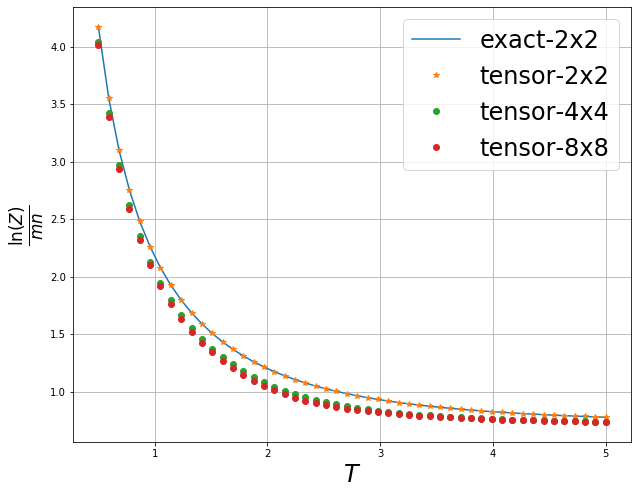

In [60]:
fig, ax = plt.subplots(figsize=(10,8))

N = 4
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
ax.plot(Temp, np.log(Z)/4, '-', label='exact-2x2')

Z = np.zeros_like(beta)
Z_RG = []
for i in range(3):
    Z_RG.append(np.zeros_like(beta))

for i in range(beta.size):
    T_RG = [mat_T(beta[i], 0 )]
    Z_RG[0][i] = contract_2x2(T_RG[0], T_RG[0], T_RG[0], T_RG[0])

    T_RG.append(TTTT_2_T(T_RG[0], T_RG[0], T_RG[0], T_RG[0]))
    Z_RG[1][i] = contract_2x2(T_RG[1], T_RG[1], T_RG[1], T_RG[1])

    T_RG.append(TTTT_2_T(T_RG[1], T_RG[1], T_RG[1], T_RG[1]))
    Z_RG[2][i] = contract_2x2(T_RG[2], T_RG[2], T_RG[2], T_RG[2])
    
ax.plot(Temp, np.log(Z_RG[0])/2**2, '*', label='tensor-2x2')
ax.plot(Temp, np.log(Z_RG[1])/4**2, 'o', label='tensor-4x4')
ax.plot(Temp, np.log(Z_RG[2])/8**2, 'o', label='tensor-8x8')

ax.legend(fontsize=24)
ax.grid()
ax.set_xlabel(r'$T$', fontsize=24)
ax.set_ylabel(r'$\frac{\ln(Z)}{mn}$', fontsize=24)

## Energy per bond

Text(0, 0.5, 'Energy per bond')

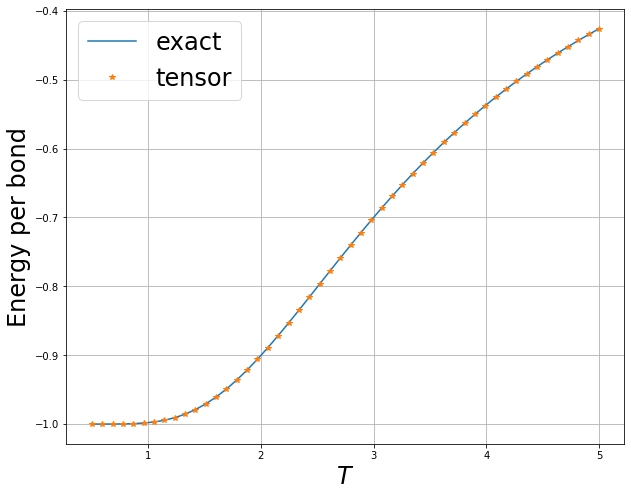

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

N = 4
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
ax.plot(Temp, E/(2*N), '-', label='exact')

E = np.zeros_like(beta)
for i in range(beta.size):
    T = mat_T(beta[i], 0 )
    Tz = mat_Tz(beta[i], 0 )
    E[i] = -J*contract_2x2(Tz, Tz, T, T)/contract_2x2(T, T, T, T)
ax.plot(Temp, E, '*', label='tensor')

ax.legend(fontsize=24)
ax.grid()
ax.set_xlabel(r'$T$', fontsize=24)
ax.set_ylabel('Energy per bond', fontsize=24)

Text(0, 0.5, 'Energy per bond')

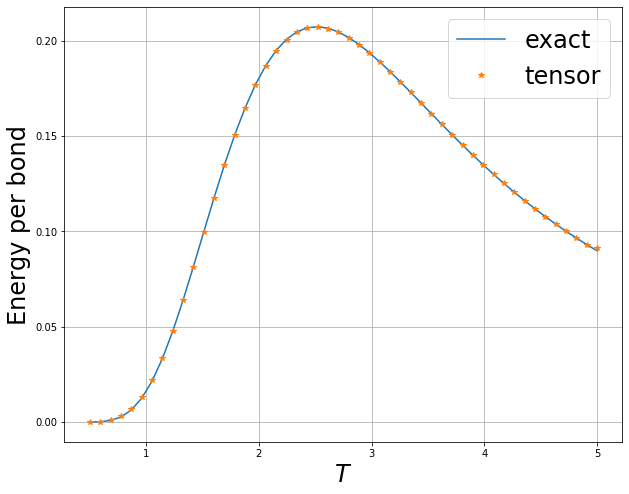

In [38]:
fig, ax = plt.subplots(figsize=(10,8))

N = 4
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
ax.plot(Temp, C/(2*N), '-', label='exact')

E = np.zeros_like(beta)
for i in range(beta.size):
    T = mat_T(beta[i], 0 )
    Tz = mat_Tz(beta[i], 0 )
    E[i] = -J*contract_2x2(Tz, Tz, T, T)/contract_2x2(T, T, T, T)
ax.plot(Temp, np.gradient(E, Temp), '*', label='tensor')

ax.legend(fontsize=24)
ax.grid()
ax.set_xlabel(r'$T$', fontsize=24)
ax.set_ylabel('Energy per bond', fontsize=24)

## C_max

Text(0, 0.5, 'Energy per bond')

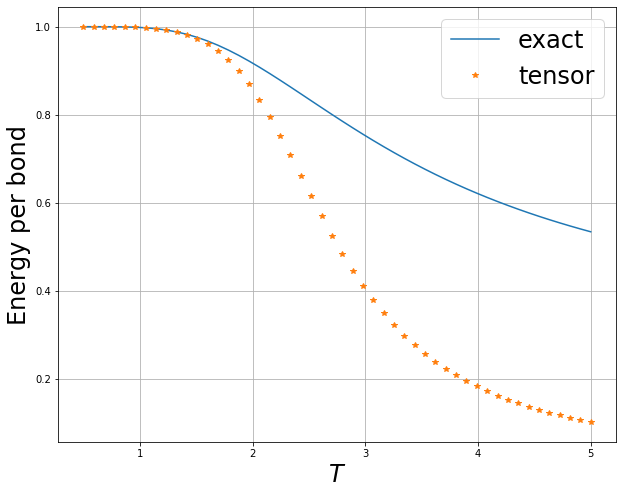

In [24]:
fig, ax = plt.subplots(figsize=(10,8))

N = 4
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
ax.plot(Temp, M_sqr/N**2, '-', label='exact')

C_max = np.zeros_like(beta)
for i in range(beta.size):
    T = mat_T(beta[i], 0 )
    Tz = mat_Tz(beta[i], 0 )
    T_1 = TTTT_2_T(T, T, T, T)    
    Tz_1 = TTTT_2_T(Tz, T, T, T)
#     C_max[i] = contract_2x2(Tz, T, T, Tz)/contract_2x2(T, T, T, T)
    C_max[i] = contract_2x2(Tz_1, T_1, T_1, Tz_1)/contract_2x2(T_1, T_1, T_1, T_1)    
ax.plot(Temp, C_max, '*', label='tensor')

ax.legend(fontsize=24)
ax.grid()
ax.set_xlabel(r'$T$', fontsize=24)
ax.set_ylabel('Energy per bond', fontsize=24)

Text(0, 0.5, 'Energy per bond')

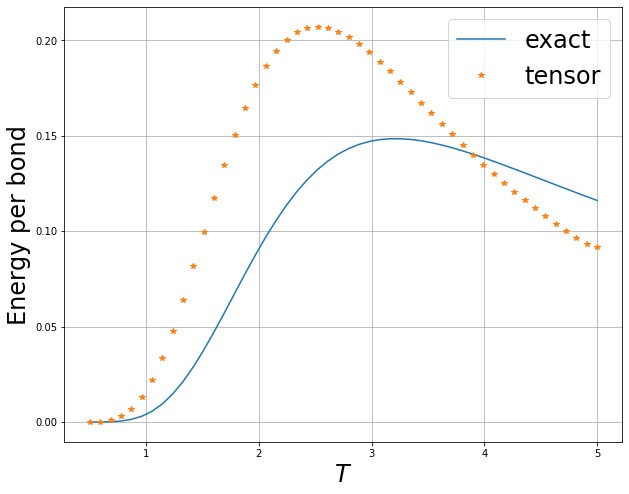

In [46]:
fig, ax = plt.subplots(figsize=(10,8))

N = 4
Temp = np.linspace(0.5, 5, 50)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p = exact(beta)
ax.plot(Temp, chi_p/N, '-', label='exact')

C_max = np.zeros_like(beta)
for i in range(beta.size):
    T = mat_T(beta[i], 0 )
    Tz = mat_Tz(beta[i], 0 )
    C_max[i] = contract_2x2(Tz, T, T, Tz)/contract_2x2(T, T, T, T)
ax.plot(Temp, -np.gradient(C_max, Temp), '*', label='tensor')

ax.legend(fontsize=24)
ax.grid()
ax.set_xlabel(r'$T$', fontsize=24)
ax.set_ylabel('Energy per bond', fontsize=24)

## HOTRG

In [50]:
#==================================================================#
##           
##          3--------3       
##     0--(TOd)--2--(T0)--0 = 2--Aup--0
##          1        1           3 1
##
##          3        3           3 1
##     0--(T3d)--2--(T3)--0 = 2--Adn--0
##          1--------1 

##     2--Aup--0    
##        3 1       1--  --0
##        | |    =     AA
##        3 1       3--  --2 
##     2--Adn--0
#==================================================================#

In [51]:
def updat_pure( T0,T3,Bond,dcut):
    
    if Bond=='x':
        T0 = np.transpose( T0,(1,0,3,2) )
        T3 = np.transpose( T3,(1,0,3,2) )
        
    dimT0 = T0.shape
    dimT3 = T3.shape
    
    Aup = np.tensordot( T0, T0.conjugate(), axes= ([2,3],[2,3]))
    Adown= np.tensordot( T3, T3.conjugate(), axes= ([2,1],[2,1]))
    AA =  np.tensordot( Aup, Adown, axes= ([1,3],[1,3]))
    AA =  np.reshape( np.transpose (AA,(0,2,1,3)),(dimT0[0]*dimT3[0],dimT0[0]*dimT3[0]))
    
    Yo,Zo = eig_all(AA)
    dc1 = np.min([np.sum(Yo>10.**(-10)),dcut])
    UU = Zo [0:dc1,:];  UUT =(Zo.T[:,0:dc1]).conj();
    
    AO = merge_two(T0,T3,UU,UUT); N1 = np.max(abs(AO));
    NewT = AO/N1
    
    if Bond=='x': np.transpose(NewT,(1,0,3,2))
    
    return NewT,UU,UUT,N1